[ 3.+1.j -3.+3.j  1.+3.j ... -1.+3.j  1.-1.j  1.+1.j]
[-1.00750505-3.00405205j -3.00291378+0.98680615j -1.00474208-0.9866916j
 ...  0.98634536+3.00700733j  3.00727134+2.99070855j
  3.00169773+1.01276879j]
len(baseband_symbols)
2080
len(a_demodulated)
[0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1

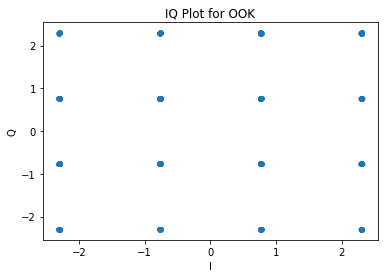

In [48]:
# FOR INCORPORATING PULSE SHAPING

import preamble_test
import symbol_mod_QAM
import symbol_demod_QAM
import numpy as np
import preamble_generator
import data_source
import mode_preconfiguration
import pulse_shaping
import matched_filtering
import time
import matplotlib.pyplot as plt

fs = 750000.0	       # maximum output sampling rate sustainable for pluto streaming: 2750000 (Hz), for m2k streaming: 750000 (Hz) 
Ts = 1.0 / fs          # sampling period in seconds
f0 = 0.0               # homodyne (0 HZ IF)
M = 6                  # oversampling factor
T = M*Ts               # symbol period in seconds
Rs = 1/T               # symbol rate
segment_size = 1504    # One Transport Stream (TS) packet=188Bytes=1504 bits
R = 5                 # Packet Ratio: number of segments contained in our larger OOK packet 
N = R*segment_size     # OOK Packet Length (equals R* segment_size)

b = "40k"             #bandwidth of Iperf client (UDP test)

test_packet_num = 20  #number of ADALM packets transmitted in Iperf test
        
scheme = "QAM"
Mode = 4

serverSock, generated_sequence, sequence_counter, l = mode_preconfiguration.tx_mode_preconfig(Mode, R, segment_size, N, b, test_packet_num)
preamble_ones_length = 180
preamble = preamble_generator.preamble_generator(preamble_ones_length)
#preamble = np.zeros(200)

Bits = data_source.data_source(Mode, serverSock, generated_sequence, sequence_counter, l)
#Bits = Bits[0:96]

packet_bits = np.append(preamble, Bits)

preamble_length = len(preamble)

total_samples, samples_perbit, fs_in, Ts_in =  mode_preconfiguration.rx_mode_preconfig(scheme,N,preamble_length,M,fs)

################################
known_preamble_bits = preamble_generator.preamble_generator(preamble_ones_length)
known_preamble_symbols = symbol_mod_QAM.symbol_mod(known_preamble_bits, "OOK", len(known_preamble_bits))
known_preamble = np.abs(pulse_shaping.pulse_shaping(known_preamble_symbols, samples_perbit, fs_in, 'rect', None, None))
#################################

######################
# Throughput calc start
start = time.time()

baseband_symbols = symbol_mod_QAM.symbol_mod(packet_bits, scheme, preamble_length)
print(baseband_symbols[200:])

pulse_shape = 'rrc'
baseband = pulse_shaping.pulse_shaping(baseband_symbols, M, fs, pulse_shape, 0.9, 8)

#bb_amplitude = 0.2
bb_amplitude = 1
buffer = bb_amplitude*baseband

buffer_IQ = buffer

I_data = np.real(buffer_IQ)
Q_data = np.imag(buffer_IQ)

a_in1 = buffer

alpha = 0.9 #roll-off factor of the RRC matched-filter

L = 8

#############################
oldN = N
if(scheme == "QPSK"):
        N = int(N/2)

if(scheme == "QAM"):
        N = int(N/4)

payload_start = len(known_preamble)

payload_before_correction = a_in1[payload_start:(payload_start + N*samples_perbit)]

ones_length = preamble_length - 20

payload_and_ones = a_in1[int(payload_start-ones_length*samples_perbit):(payload_start + N*samples_perbit)]

payload_corrected = payload_and_ones[ones_length*samples_perbit:]

baseband_signal_I_new = np.real(payload_corrected)
baseband_signal_Q_new = np.imag(payload_corrected)

N = oldN
#######################################



symbols_I = matched_filtering.matched_filtering(baseband_signal_I_new, samples_perbit, fs_in, alpha, L, pulse_shape)

symbols_Q = matched_filtering.matched_filtering(baseband_signal_Q_new, samples_perbit, fs_in, alpha, L, pulse_shape)



#Remove the L/2 samples at the beginning and L/2 samples at the end caused by group delay of the filter

if (pulse_shape == 'rect'):
    symbols_I = symbols_I[1:]
    symbols_Q = symbols_Q[1:]
elif (pulse_shape == 'rrc'):
    symbols_I = symbols_I[L-1:(len(symbols_I))-L]
    symbols_Q = symbols_Q[L-1:(len(symbols_Q))-L]
    
print((symbols_I+1j*symbols_Q)/6)

#Plot the received signal constellation

if (scheme == 'QPSK'):  
    channel_gain = np.mean(np.abs(symbols_I))/(2/3)
elif (scheme == 'QAM'):  
    channel_gain = np.mean(np.abs(symbols_I))/(3/2)
else:
    channel_gain = np.mean(np.abs(symbols_I))

symbols = np.array([symbols_I,symbols_Q])

a_demodulated = symbol_demod_QAM.symbol_demod(symbols, scheme, channel_gain, preamble_length)
print("len(baseband_symbols)")
print(len(baseband_symbols))
print("len(a_demodulated)")
print(a_demodulated)
print("len(Bits)")
print(Bits)
print("len(symbols_I)")
print(len(symbols_I))
print("samples_perbit")
print(samples_perbit)


print(np.array_equal(Bits[28:-32], a_demodulated, equal_nan=False))
print(len(Bits[28:-32]))
print(len(a_demodulated))

packet_kbits = len(Bits)
total_kbits = 0
total_kbits = total_kbits+packet_kbits

window_throughput = total_kbits/(time.time()-start)

print("Total Throughput: ")
print(window_throughput)


####################
# Plot Received Constellation
showplot = True
if(showplot==True):
        #plt.ylim((-2, 1))
        #plt.xlim((1, 2))
        #for i in range(len(symbols_I)):
                #plt.plot(symbols_I[i]/channel_gain,symbols_Q[i]/channel_gain, color='blue', marker='o', markersize=1)
                
        plt.plot(symbols_I/channel_gain,symbols_Q/channel_gain, '.')
        plt.xlabel('I')
        plt.ylabel('Q')
        plt.title('IQ Plot for QAM')
        plt.show()
        plt.show()


Throughput:

OOK: 359079.2937078063

QPSK: 59763.9960436712

QAM: 22540.594137804124

- Largely determined by computational time

Throughput (tx calibrate):

OOK: 121

QPSK: 500-700

QAM: 500-700

Symbol Rate:

OOK:

QPSK:

QAM:

Theoretically, 16-QAM should have 4X the throughput of OOK, since it can represent 4 bits with a single symbol while OOK can only represent 1. 16-QAM should also have 2X the throughput of QPSK, since QPSK can only represent 2 bits with a single symbol.